In [26]:
import os
import time

import matplotlib.pyplot as plt

import pandas as pd
from pandas.core.index import Index
import xgboost as xgb

import numpy as np
import analysis_utils as au
import generalized_analysis as ga

In [3]:
# xgb hyperparameters that we are going to tune
params = {
    # general parameters
    'silent': 0,  # print message (useful to understand what's happening)
    'nthread': 4,  # number of available threads
    # booster parameters
    'eta': 0.05,  # a kind of learning rate
    'min_child_weight': 8,  # defines the min sum of weights of all observations required in a child (regularization)
    'max_depth': 8,  # defines the maximum depth of a single tree (regularization)
    'gamma': 0.7,  # specifies the minimum loss reduction required to make a split
    'subsample': 0.8,  # denotes the fraction of observations to be randomly samples for each tree
    'colsample_bytree': 0.9,  # denotes the fraction of columns to be randomly samples for each tree
    'lambda': 1,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weight
    'scale_pos_weight': 10,  # should be used in case of high class imbalance as it helps in faster convergence
    # learning task parameters
    'objective': 'binary:logistic',
    'random_state': 42,
    'tree_method': 'hist',
}

training_columns = [
    'HypCandPt', 'PtDeu', 'PtP', 'PtPi', 'nClsTPCDeu', 'nClsTPCP', 'nClsTPCPi', 'nClsITSDeu', 'nClsITSP',
    'nClsITSPi', 'nSigmaTPCDeu', 'nSigmaTPCP', 'nSigmaTPCPi', 'nSigmaTOFDeu', 'nSigmaTOFP', 'nSigmaTOFPi',
    'trackChi2Deu', 'trackChi2P', 'trackChi2Pi', 'vertexChi2', 'DCA2xyPrimaryVtxDeu', 'DCAxyPrimaryVtxP',
    'DCAxyPrimaryVtxPi', 'DCAzPrimaryVtxDeu', 'DCAzPrimaryVtxP', 'DCAzPrimaryVtxPi', 'DCAPrimaryVtxDeu',
    'DCAPrimaryVtxP', 'DCAPrimaryVtxPi', 'DCAxyDecayVtxDeu', 'DCAxyDecayVtxP', 'DCAxyDecayVtxPi', 'DCAzDecayVtxDeu',
    'DCAzDecayVtxP', 'DCAzDecayVtxPi', 'DCADecayVtxDeu', 'DCADecayVtxP', 'DCADecayVtxPi', 'TrackDistDeuP',
    'TrackDistPPi', 'TrackDistDeuPi', 'CosPA']  # 42

In [4]:
cent_bins = [[0, 10], [10, 30], [30, 50], [50, 90]]
pt_bins = [[1, 2], [2, 3], [3, 4], [4, 9]]

In [5]:
table_path = os.environ['HYPERML_TABLES_3']
signal_table_path = '{}/HyperTritonTable_19d2.root'.format(table_path)
background_table_path = '{}/HyperTritonTable_18q.root'.format(table_path)

In [6]:
analysis = ga.GeneralizedAnalysis(3, signal_table_path, background_table_path)

In [7]:
model = analysis.train_test(
    training_columns, params,
    cent_class=0,
    bkg_reduct=True, bkg_factor=10, draw=False)

number of background candidates:  11428706
number of signal candidates:  55247



/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


num rounds:  200
parameters:  {'silent': 0, 'nthread': 4, 'eta': 0.05, 'min_child_weight': 8, 'max_depth': 8, 'gamma': 0.7, 'subsample': 0.8, 'colsample_bytree': 0.9, 'lambda': 1, 'alpha': 0, 'scale_pos_weight': 10, 'objective': 'binary:logistic', 'random_state': 42, 'tree_method': 'hist'}

Ks_2sampResult(statistic=0.9865887052838072, pvalue=0.0)


In [8]:
bkg = analysis.df_data.query(analysis.total_cut)
sig = analysis.df_signal.query(analysis.total_cut)

df = pd.concat([bkg, sig])

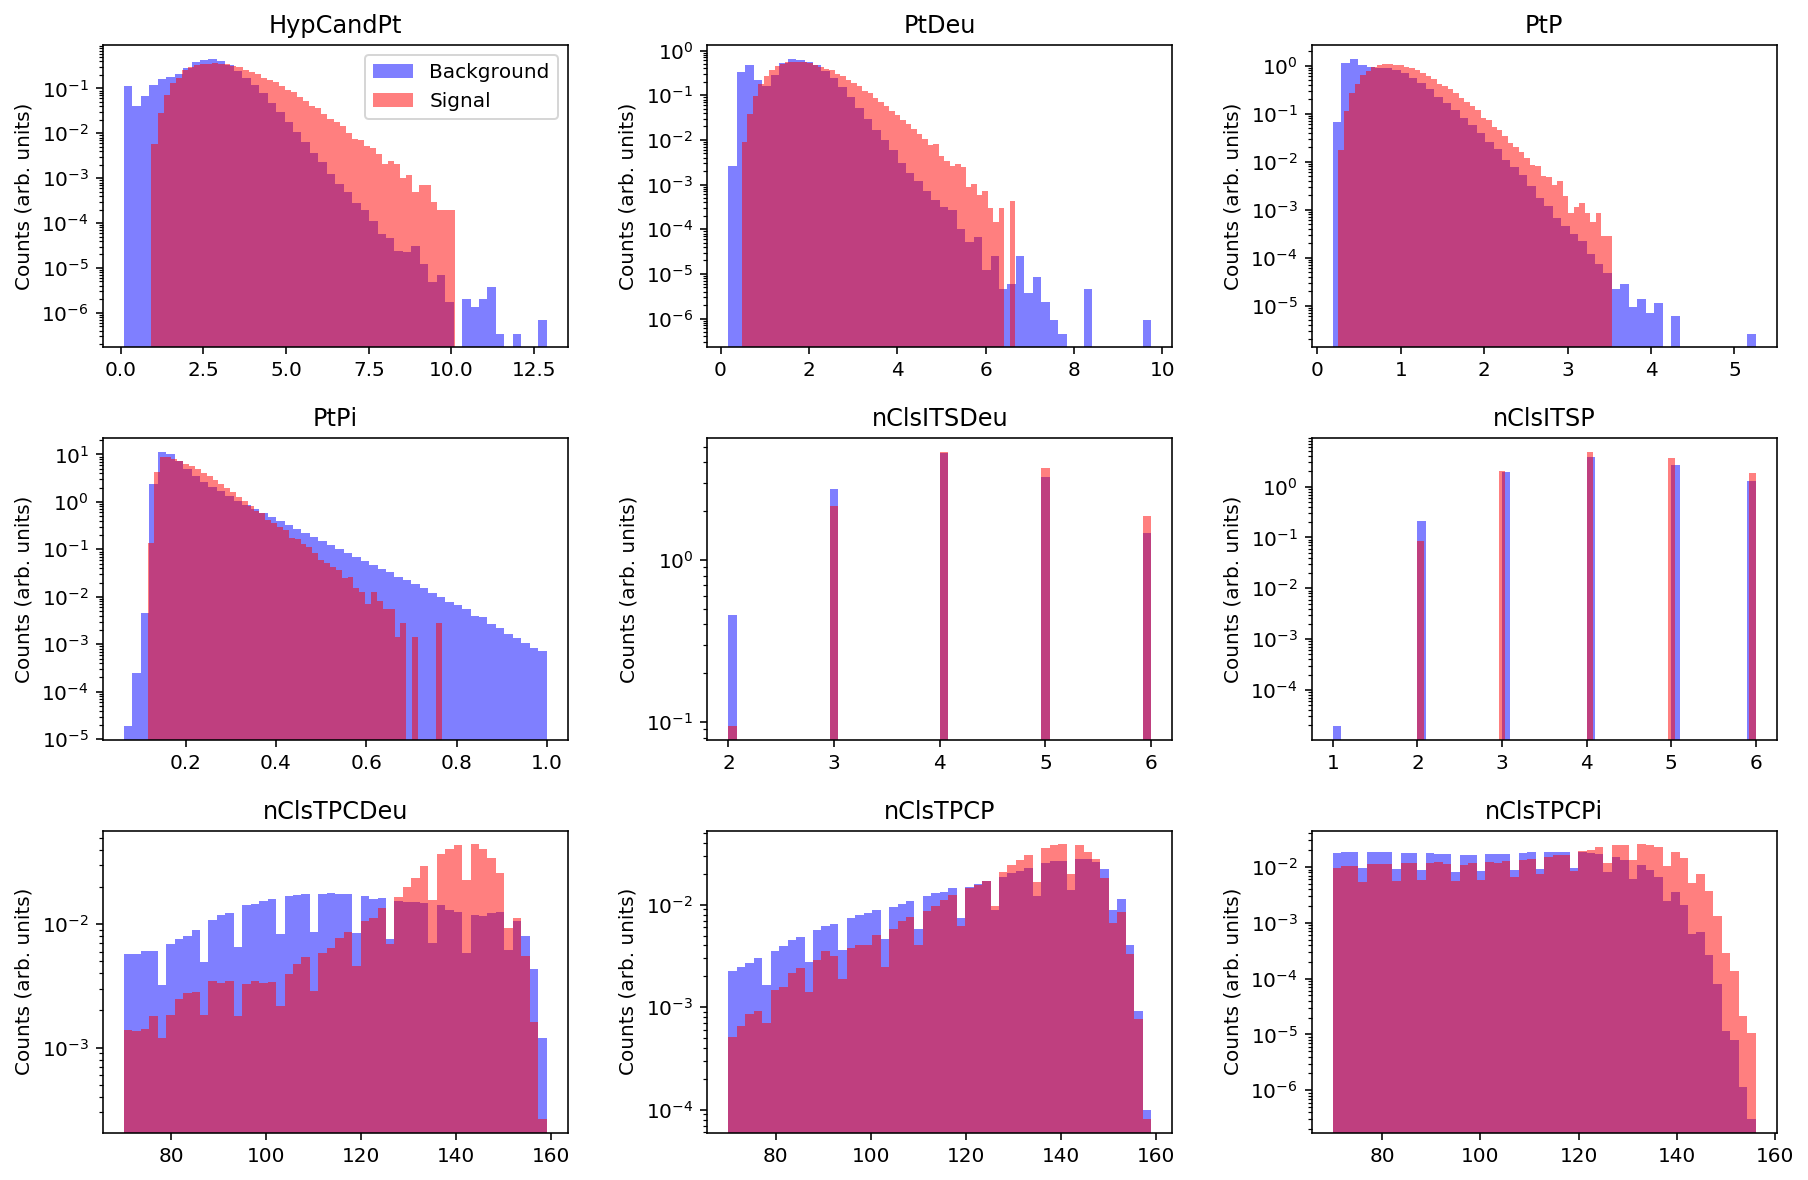

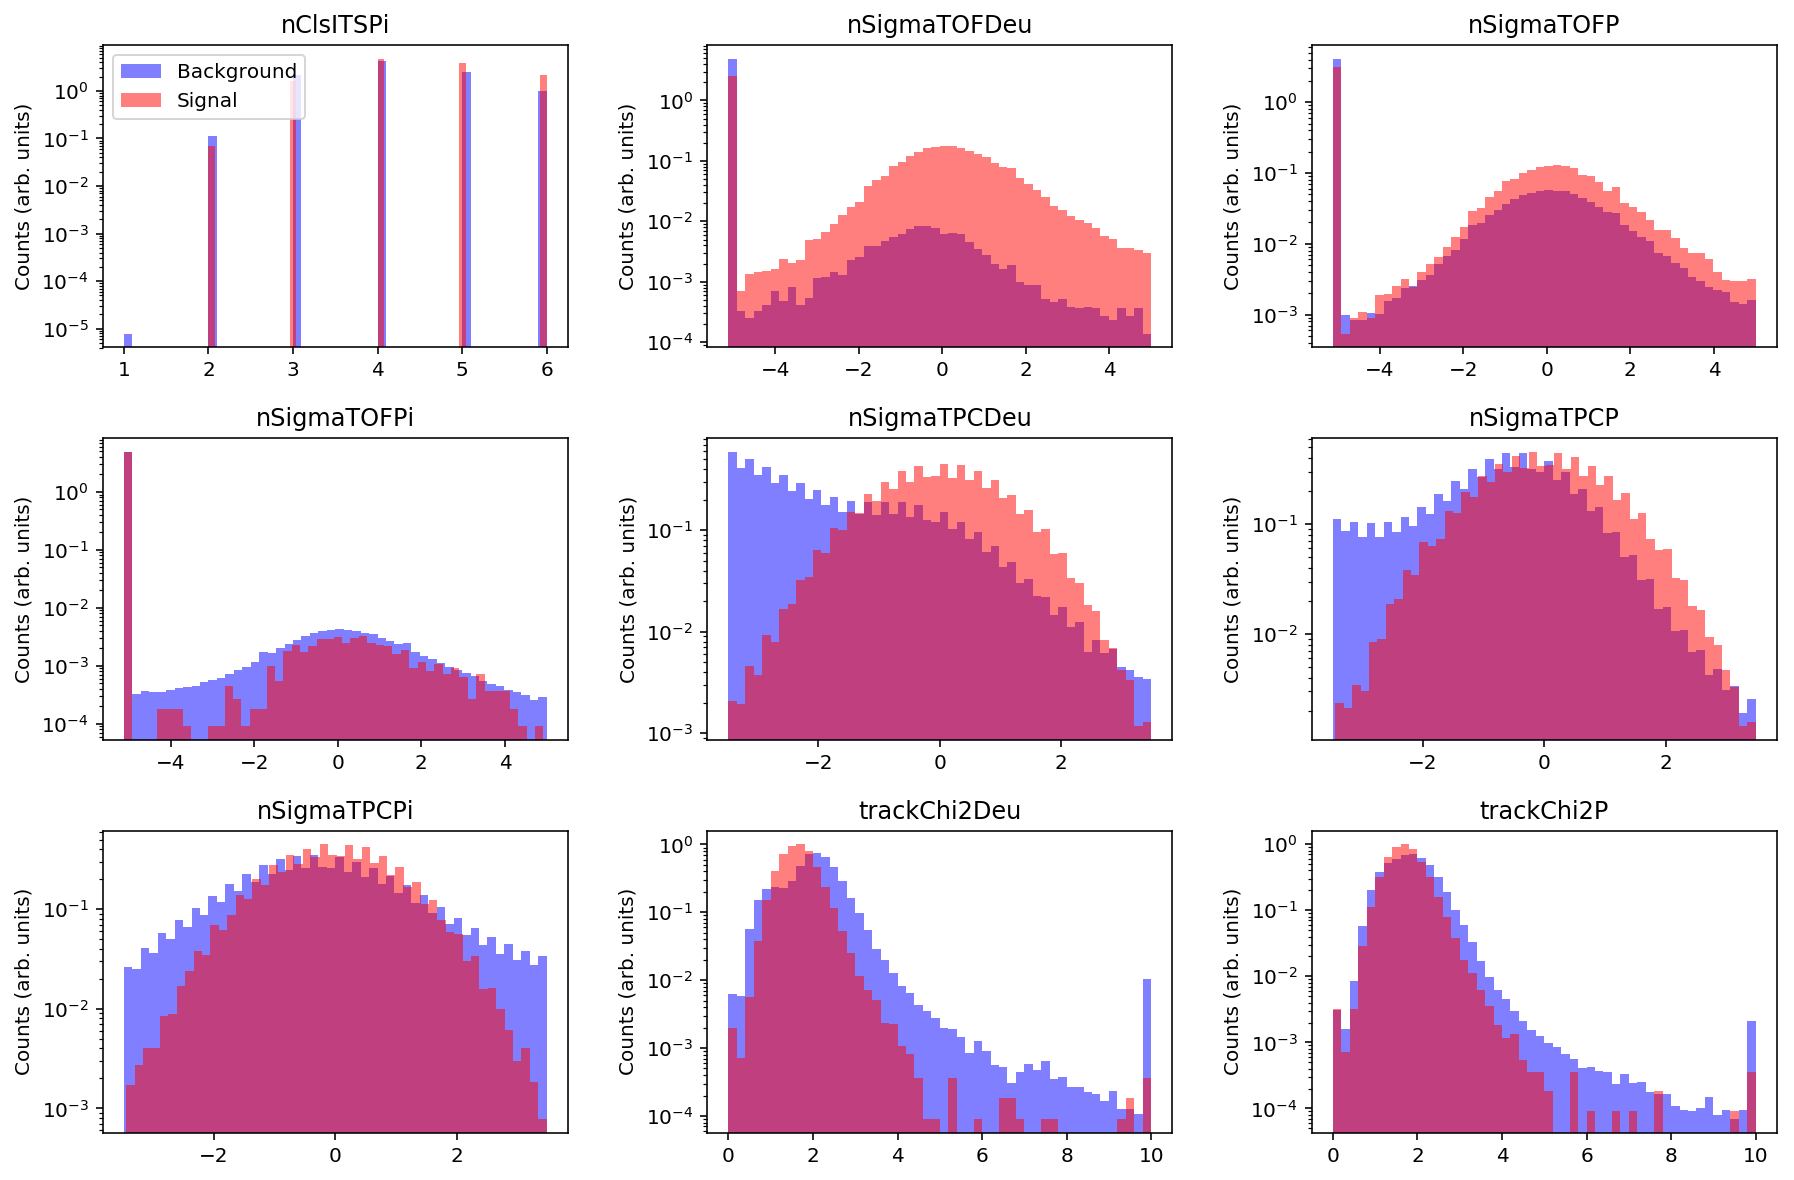

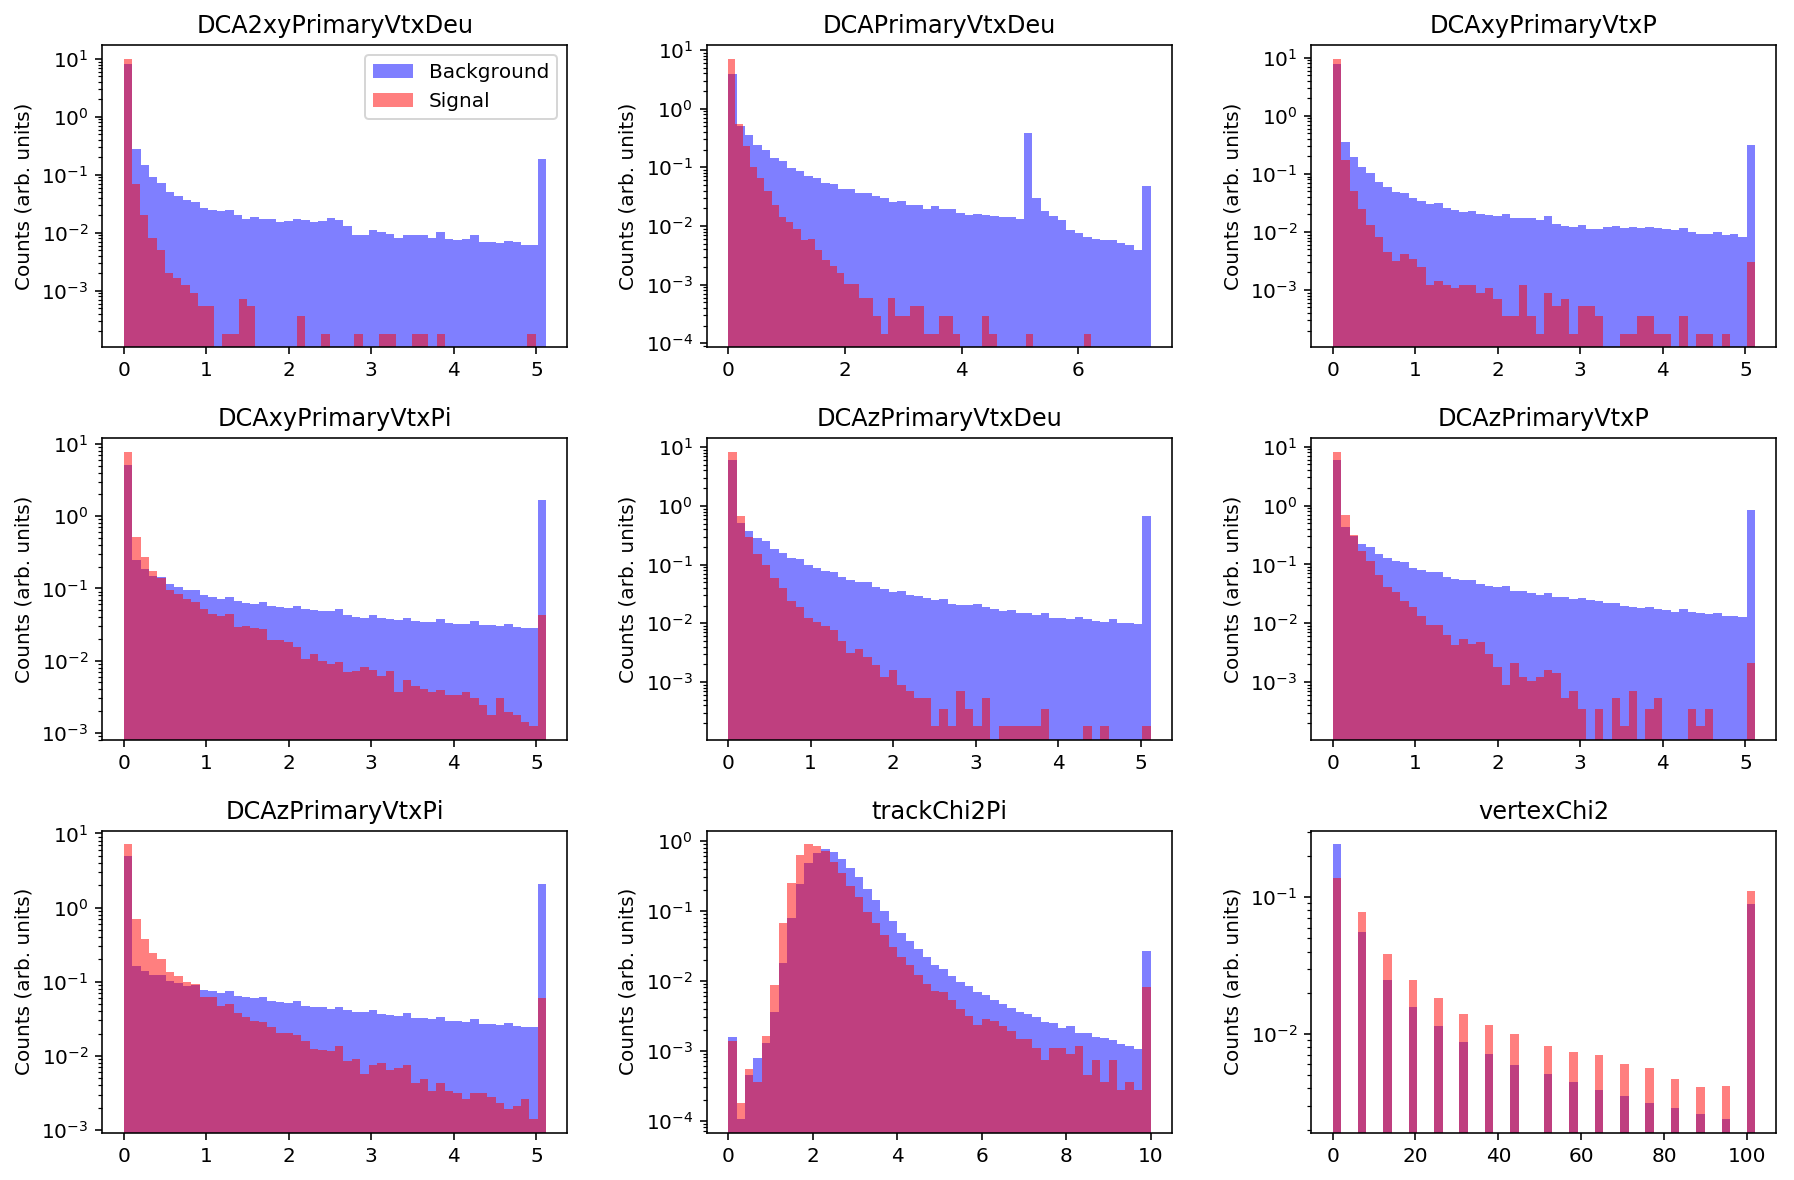

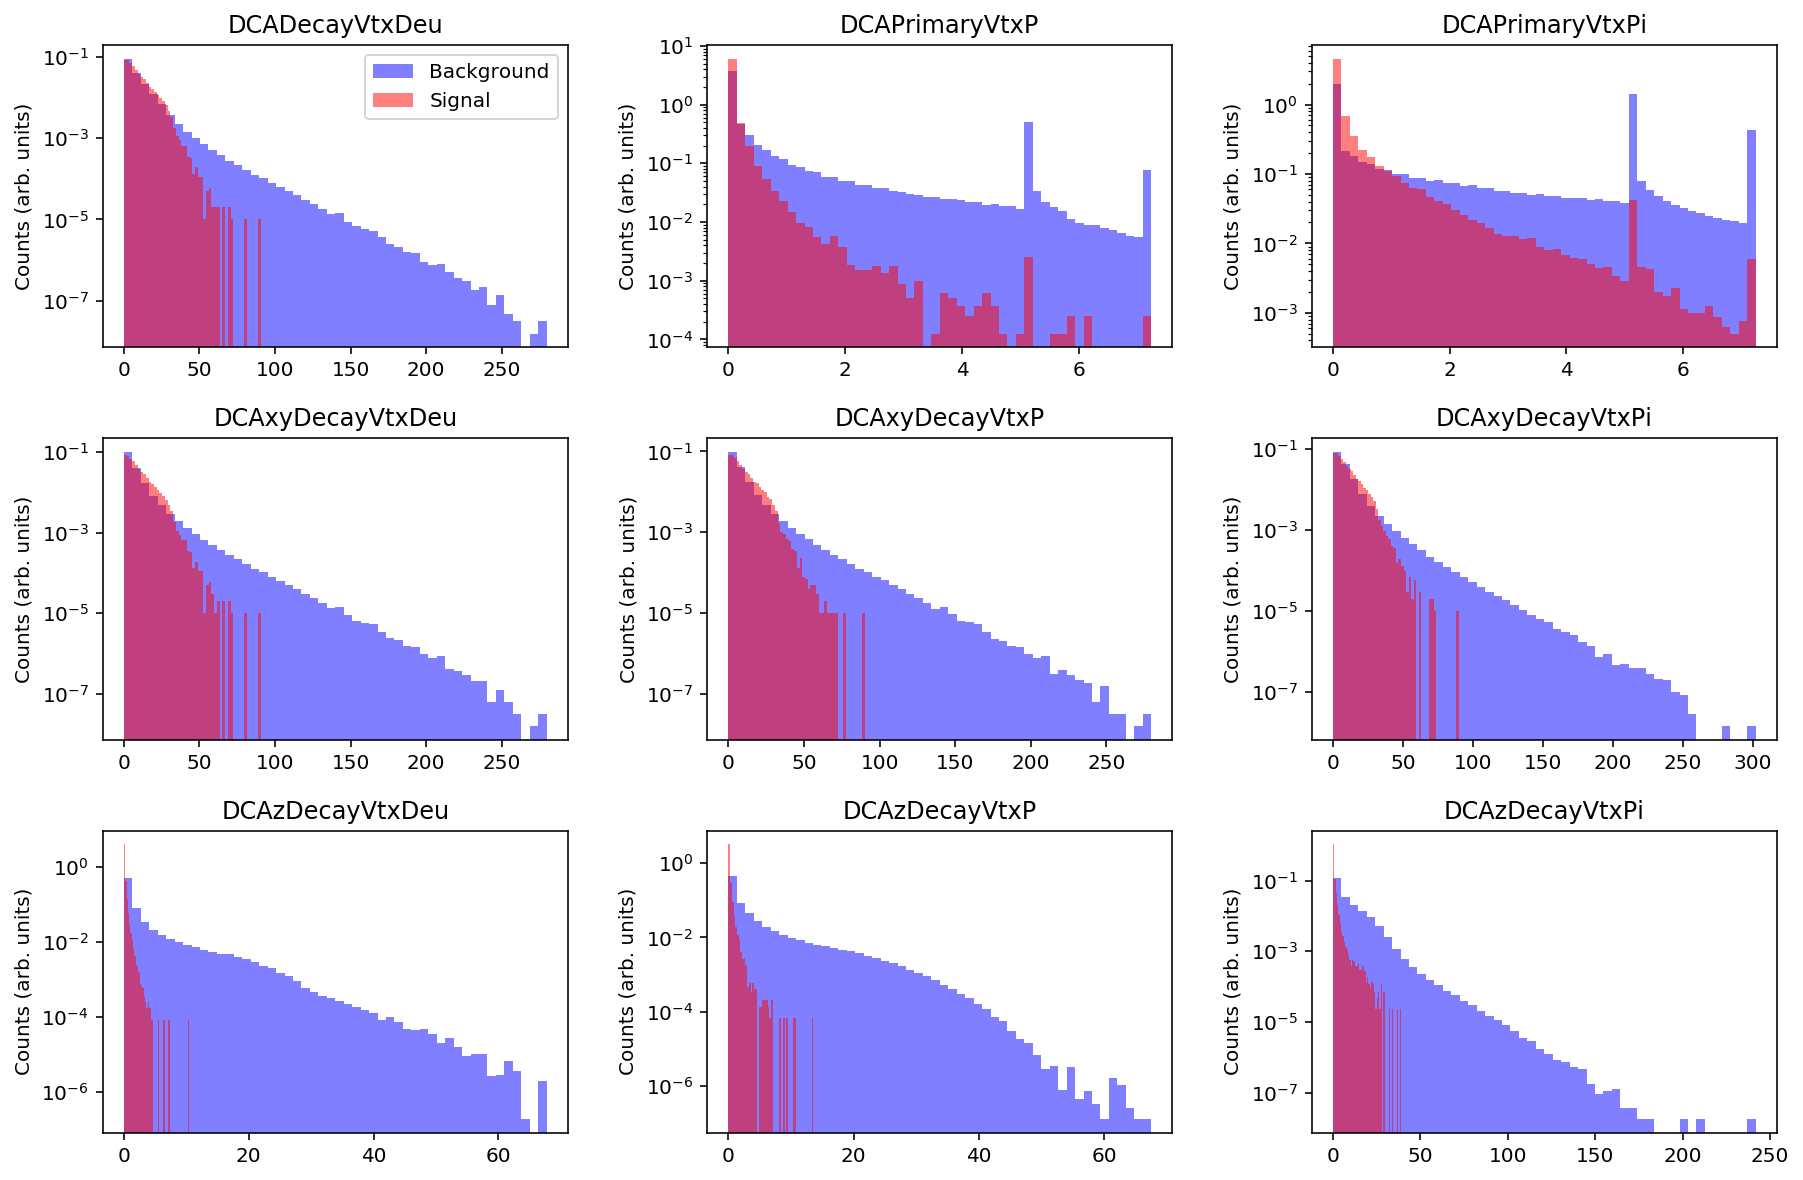

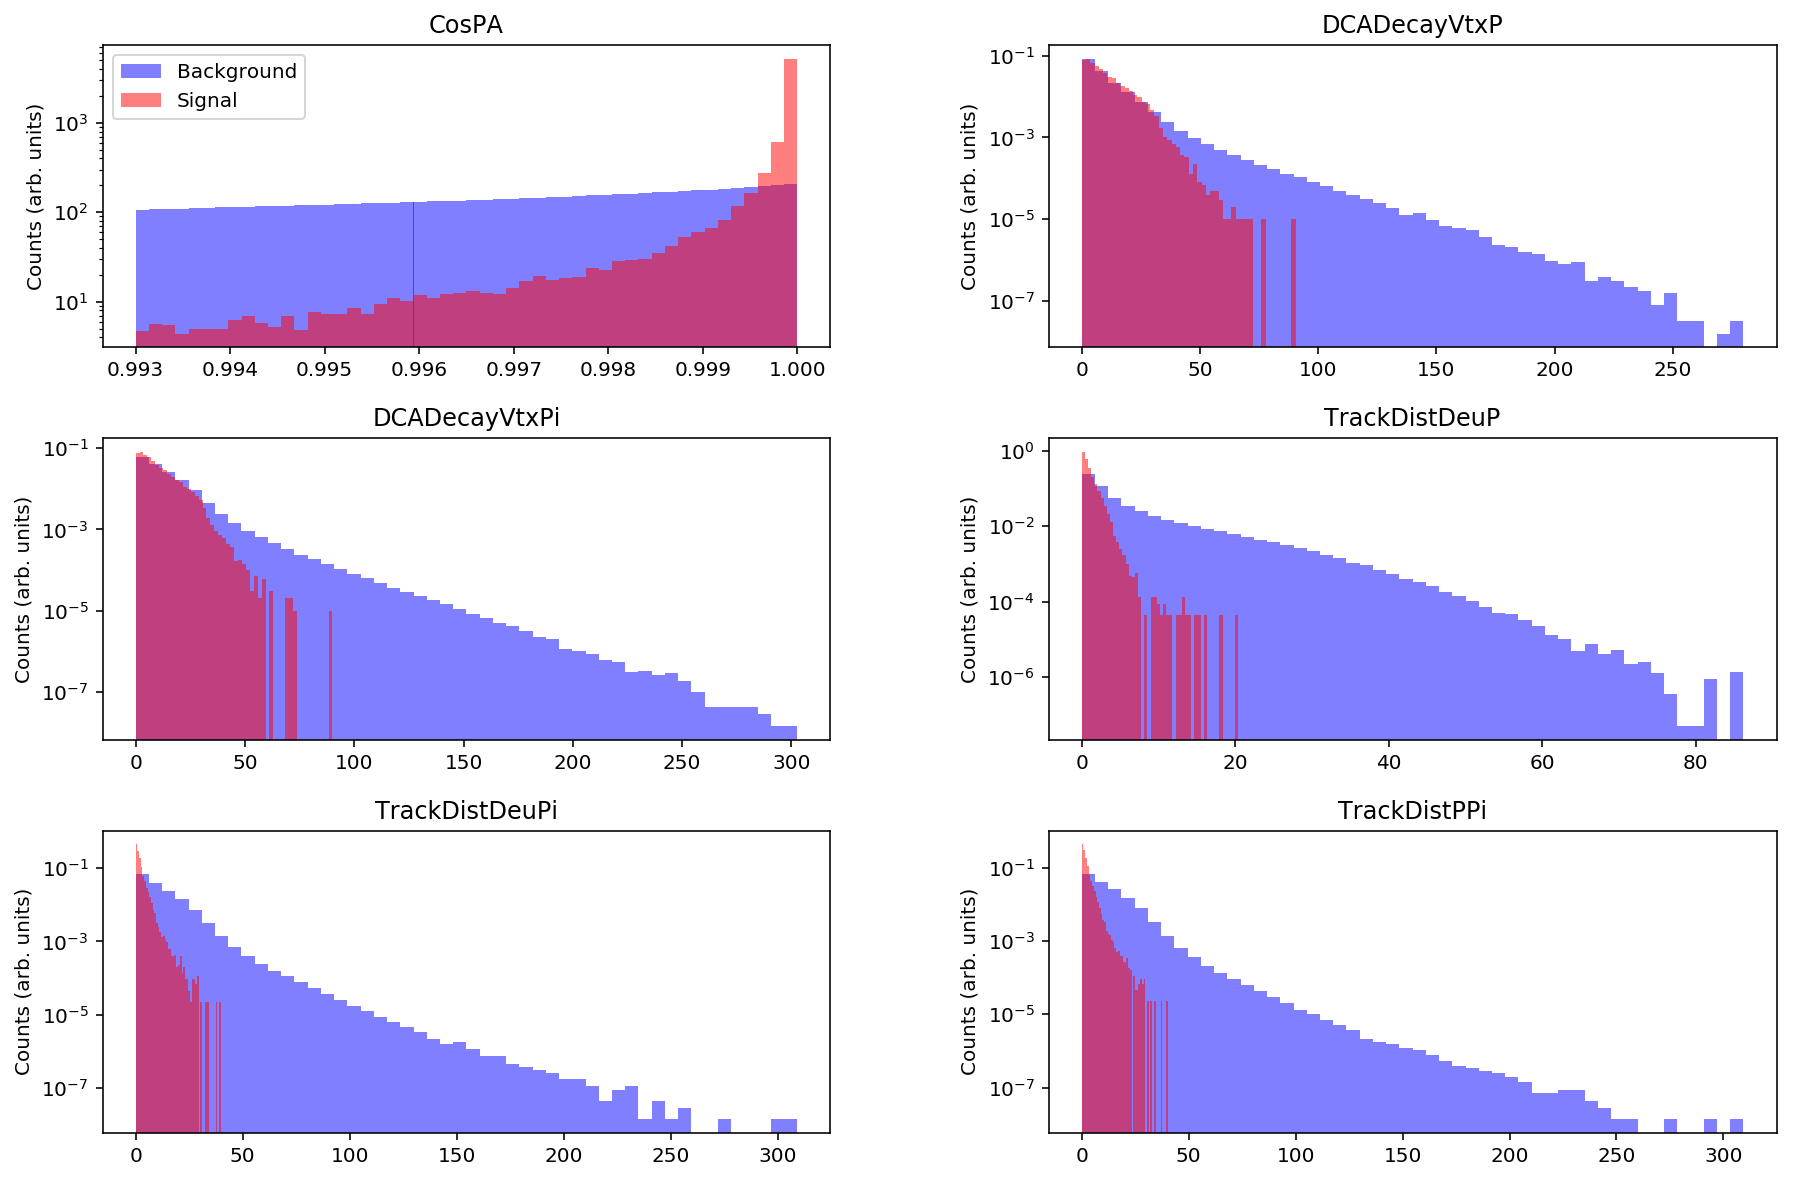

In [39]:
training_chunks = []

ind_a = 0
ind_b = len(training_columns)
for i in range(ind_a, ind_b, 9):
    x = i
    training_chunks.append(training_columns[x:x + 9])
index = 0
for chunks in training_chunks:
    plot_distr_cust(df, chunks, out_name='features{}.pdf'.format(index))
    index = index+1

In [38]:
def plot_distr_cust(df, column=None, figsize=None, bins=50, mode=3, out_name='features.pdf', **kwds):
    """Build a DataFrame and create two dataset for signal and bkg

    Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.

    X: data vector
    y: class vector
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    figsize : tuple
        The size of the figure to create in inches by default
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """

    data1 = df[df.y < 0.5]
    data2 = df[df.y > 0.5]

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]

    if figsize is None:
        figsize = [15, 10]
        
        
#     plt.Figure(figsize=figsize)

    axes = data1.hist(column=column, color='blue', alpha=0.5, bins=bins, figsize=figsize,
                      label="Background", density=True, grid=False, **kwds)
    axes = axes.flatten()
    axes = axes[:len(column)]
    data2.hist(ax=axes, column=column, color='red', alpha=0.5, bins=bins, label="Signal",
               density=True, grid=False, **kwds)[0].legend()
    for a in axes:
        a.set_ylabel('Counts (arb. units)')
        a.set_yscale('log')
    
    plt.savefig(out_name)
        
